In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load data from drive

Adience Dataset is used for training <br>
https://talhassner.github.io/home/projects/Adience/Adience-data.html

The dataset can be downloaded using wget with authentication.

In [2]:
! mkdir -p /content/data
! mkdir -p /content/weight
! mkdir -p /content/source

! cp /content/gdrive/My\ Drive/project/vgg/data/* /content/data/
! cp /content/gdrive/My\ Drive/project/vgg/weight/* /content/weight/
! cp /content/gdrive/My\ Drive/project/vgg/*.py /content/source/

In [3]:
! tar -xf data/faces.tar.gz -C data/
! rm data/faces.tar.gz

In [4]:
! mkdir -p data/faces
! mv data/data/faces/* data/faces/
! rm -rf data/data

## Reading CSV

The text files named fold_0_data.txt thru fold_5_data.txt have mapping of filenames to resprective age and gender of the person in image. Since we only predict age, we ignore gender and other classes

In [ ]:
import pandas as pd

In [ ]:
frames = []
folder_path = "data/"

for i in range(5):
    temp_df = pd.read_csv(folder_path + "fold_" + str(i) + "_data.txt", delimiter="\t")
    frames.append(temp_df)

df = pd.concat(frames)

In [ ]:
df.head()

In [ ]:
"""
FINAL CLASSES
(00, 02)
(04, 06)
(08, 12)
(15, 20)
(25, 32)
(38, 43)
(48, 53)
(60, 100)
None
"""

# for cleaning anomalies
map_dict = {
    "13": "(08, 12)",
    "2" : "(00, 02)",
    "22": "(15, 20)",
    "23": "(25, 32)",
    "29": "(25, 32)",
    "3" : "(00, 02)",
    "32": "(25, 32)",
    "34": "(25, 32)",
    "35": "(25, 32)",
    "36": "(38, 43)",
    "42": "(38, 43)",
    "45": "(38, 43)",
    "46": "(48, 53)",
    "55": "(48, 53)",
    "56": "(48, 53)",
    "57": "(60, 100)",
    "58": "(60, 100)",
    
    "(8, 23)" : "(08, 12)",
    "(27, 32)": "(25, 32)",
    "(38, 42)": "(38, 43)",
    "(38, 48)": "(38, 43)",

    "(00, 02)" : "(00, 02)"
    "(04, 06)" : "(04, 06)"
    "(08, 12)" : "(08, 12)"
    "(15, 20)" : "(15, 20)"
    "(25, 32)" : "(25, 32)"
    "(38, 43)" : "(38, 43)"
    "(48, 53)" : "(48, 53)"
    "(60, 100)": "(60, 100)"
}

def map_func(x):
    if x in map_dict:
        return map_dict[x]
    else:
        return x

df["age"] = df["age"].map(map_func)

In [ ]:
df["age"].value_counts()

## Restructuring Directory

The directory structure is not recognizable for pytorch dataloaders. <br>
To restructure the tree so that it is readable, every file is moved under the subfolder named after its class.

In [ ]:
import os
import shutil

In [ ]:
folder_path = "/content/data/faces/"

In [ ]:
file_list = []
formats = ["jpg", "png"]

for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)
    if os.path.isdir(subpath):
        for f in os.listdir(subpath):
            filepath = os.path.join(subpath, f)
            part = f.split(".")
            if os.path.isfile(filepath) and part[-1] in formats:
                file_list.append((filepath, f))

print(len(file_list))

In [ ]:
# DONT INTERRUPT WHILE RUNNING
# SHOWS PROGRESS

im_len = len(file_list)

for i, (filepath, filename) in enumerate(file_list):

    # get the identifiers
    parts = filename.split(".")
    user_id = filepath.split("/")[-2]
    file_id = parts[-2] + "." + parts[-1]
    face_id = int(parts[-3])

    # find class
    class_ = df[
       (df["user_id"] == user_id) & 
       (df["original_image"] == file_id) & 
       (df["face_id"] == face_id)
    ]["age"].values[0]

    new_path = os.path.join(folder_path, class_)
    
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    # move file
    new_path = os.path.join(new_path, filename)
    shutil.move(filepath, new_path)
    
    # progress
    prog = (20 * (i + 1)) // im_len
    print("\r[" + "="*prog + "_"*(20-prog) + "]", end="")

In [ ]:
# delete unwanted files or empty folders
folder_path = "/content/data/faces/"

for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)

    if os.path.isdir(subpath):
        if subdir[0] != "(":
            shutil.rmtree(subpath)
    elif os.path.isfile(subpath):
        os.remove(subdir)

In [ ]:
# list the classes
! ls data/faces

In [ ]:
# compress and save to drive for future purposes
! tar -czvf faces.tar.gz data/faces
! cp faces.tar.gz /content/gdrive/My\ Drive/project/vgg/data/

## Label correction

Turns out the classes sorting is messed up because of 1st digit sorting. <br>
This creates problems for manual prediction checking, and neatness. <br>
This can be corrected by adding an extra zero in the beginning.

In [5]:
! mkdir -p 'data/faces/(00, 02)'
! mkdir -p 'data/faces/(04, 06)'
! mkdir -p 'data/faces/(08, 12)'

In [6]:
! mv 'data/faces/(0, 2)'/* 'data/faces/(00, 02)'
! mv 'data/faces/(4, 6)'/* 'data/faces/(04, 06)'
! mv 'data/faces/(8, 12)'/* 'data/faces/(08, 12)'

In [7]:
! rm -rf 'data/faces/(0, 2)'
! rm -rf 'data/faces/(4, 6)'
! rm -rf 'data/faces/(8, 12)'

In [8]:
! ls data/faces

'(00, 02)'  '(08, 12)'	'(25, 32)'  '(48, 53)'
'(04, 06)'  '(15, 20)'	'(38, 43)'  '(60, 100)'


## Preparation

In [9]:
import torch
import source.models as models
import source.worker as worker
import source.loader as loader

In [ ]:
# the mean and std of dataset are found by running this
# takes some time to iterate twice
loader.find_mean_std("data/faces")

In [10]:
loader.random_scale = (0.8, 1.0)
loader.mean = [0.437, 0.340, 0.304]
loader.std  = [0.286, 0.252, 0.236]

In [11]:
# Dataset Loader to feed into network
# 20% of data is used for validation
loaders = loader.split_loader("data/faces", valid_frac=0.2, batch_size=32)

In [12]:
# pretrained weights - for convolution layers
state = loader.load_pth("weight/vgg_face_dag.pth")

## Model initialization

In [13]:
model = models.vgg16(num_classes=8)

In [14]:
# pretrained vgg-face
model.load_weights(state)

   features.0.weight         Loaded
   features.0.bias           Loaded
   features.2.weight         Loaded
   features.2.bias           Loaded
   features.5.weight         Loaded
   features.5.bias           Loaded
   features.7.weight         Loaded
   features.7.bias           Loaded
   features.10.weight        Loaded
   features.10.bias          Loaded
   features.12.weight        Loaded
   features.12.bias          Loaded
   features.14.weight        Loaded
   features.14.bias          Loaded
   features.17.weight        Loaded
   features.17.bias          Loaded
   features.19.weight        Loaded
   features.19.bias          Loaded
   features.21.weight        Loaded
   features.21.bias          Loaded
   features.24.weight        Loaded
   features.24.bias          Loaded
   features.26.weight        Loaded
   features.26.bias          Loaded
   features.28.weight        Loaded
   features.28.bias          Loaded
   classifier.0.weight       Ignored
   classifier.0.bias       

In [15]:
# gives parameter count and memory in MB
model.memory_usage()

Conv   : 14714688
FC     : 13112328
-----------------
Total  : 27827016
Memory : 106.15MB



In [16]:
# train for one epoch
worker.train(model, loaders, lr=0.01, epochs=3)

=> training vgg16
=> found cuda compatible gpu
=> checkpoints will be saved as checkpoint.pth
=> training started at Mar-10 17:26:50

EPOCH : 0
(466/466)[====================]       Loss: 0.5370 (1.2275)        Acc@1: 77.778 (52.007)       Acc@5: 100.000 (96.167)
VALIDATION :
(117/117)[====================]       Loss: 0.9250 (0.8929)        Acc@1: 50.000 (62.997)       Acc@5: 100.000 (99.436)

EPOCH : 1
(466/466)[====================]       Loss: 0.5494 (0.9337)        Acc@1: 77.778 (64.015)       Acc@5: 100.000 (99.107)
VALIDATION :
(117/117)[====================]       Loss: 0.5059 (0.8315)        Acc@1: 66.667 (65.602)       Acc@5: 100.000 (99.329)

EPOCH : 2
(466/466)[====================]       Loss: 0.8179 (0.7982)        Acc@1: 66.667 (68.640)       Acc@5: 100.000 (99.483)
VALIDATION :
(117/117)[====================]       Loss: 0.8233 (0.8045)        Acc@1: 83.333 (69.603)       Acc@5: 100.000 (99.329)


In [17]:
# save checkpoint to drive
! cp checkpoint.pth /content/gdrive/My\ Drive/project/vgg/checkpoint.pth

## Confusion Matrix

In [ ]:
# to try out saved version
! cp /content/gdrive/My\ Drive/project/vgg/checkpoint.pth /content/

check = loader.load_pth("checkpoint.pth")
model.load_weights(check["state_dict"])

In [18]:
valid_loader = loaders[1]
conf_mat = worker.confusion_matrix(model, valid_loader)

VALIDATION :
(117/117)[====================]


In [19]:
for row in conf_mat:
    for elem in row:
        print("%.2f"%(elem*100), end="\t")
    print("")

85.74	13.88	0.00	0.00	0.00	0.00	0.00	0.38	
4.03	82.87	9.82	0.25	2.02	0.50	0.25	0.25	
0.22	5.41	75.76	3.68	13.42	1.30	0.22	0.00	
0.27	0.82	6.59	33.24	53.02	5.22	0.82	0.00	
0.00	0.09	1.18	2.09	78.56	17.44	0.64	0.00	
0.00	0.58	0.97	0.39	26.99	63.50	6.21	1.36	
0.00	1.10	1.10	0.55	7.18	39.23	39.78	11.05	
0.00	0.56	0.56	0.00	2.25	23.60	29.78	43.26	


In [20]:
# one-off accuracy
ncls = len(conf_mat)
tot_acc = 0

for i in range(ncls):
    
    acc = conf_mat[i][i]

    # add left
    if i > 0:
        acc += conf_mat[i][i-1]
    
    if i < ncls - 1:
        acc += conf_mat[i][i+1]
    
    tot_acc += acc

tot_acc = tot_acc / ncls
print("%.2f" % (tot_acc * 100))

91.49


## Visualization

The corresponding predictions and target labels are visualized along with the input images.

In [21]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [22]:
# get index to class mapping
dire = "data/faces"
classes = os.listdir(dire)
classes.sort()
idx_to_class = {i:classes[i] for i in range(len(classes))}
print(idx_to_class)

{0: '(00, 02)', 1: '(04, 06)', 2: '(08, 12)', 3: '(15, 20)', 4: '(25, 32)', 5: '(38, 43)', 6: '(48, 53)', 7: '(60, 100)'}


In [23]:
# turn model to evaluation and move to cpu
model.eval()
batch_size = 32
model.to(torch.device("cpu"))

In [24]:
# inverse transform to show images
mean = loader.mean
std  = loader.std
mn_inv = [-m/s for m, s in zip(mean, std)]
sd_inv = [1/s for s in std]
inv_transform = transforms.Normalize(mean=mn_inv, std=sd_inv)

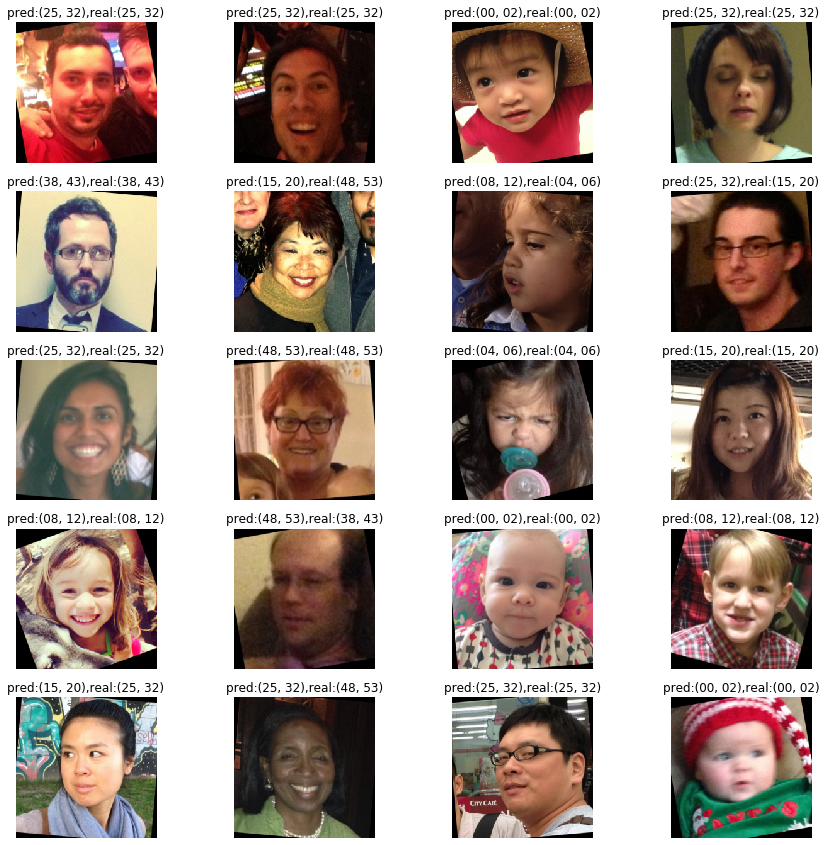

In [25]:
with torch.no_grad():
    for i, (input, target) in enumerate(valid_loader):

        output = model(input)
        _, preds = torch.max(output, 1)

        fig=plt.figure(figsize=(15, 15))
        columns = 4
        rows = 5

        for i in range(1, columns*rows + 1):

            pred_class = idx_to_class[int(preds[i])]
            real_class = idx_to_class[int(target[i])]

            ax = fig.add_subplot(rows, columns, i)
            ax.title.set_text("pred:" + pred_class + "," + "real:" + real_class)
            ax.axis("off")

            plt.imshow(inv_transform(input[i]).permute(1, 2, 0))

        break

plt.show()

## For cleaning gpu cache and reloading

In [ ]:
del loaders
del model
del state
torch.cuda.empty_cache()

In [ ]:
import importlib
importlib.reload(models)
importlib.reload(worker)
importlib.reload(loader)